### Task 1 (15 points)
Select the dataset:
- [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html)

Extra credit for the dataset below
- [ImageNet](http://www.image-net.org/) *
- [300-W](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)
- [IMDB-WIKI](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/) *
- [UTKFace](https://susanqq.github.io/UTKFace/)
- Any other, but in this case, please check with me. For example, something from [here](https://huggingface.co/datasets?task_categories=task_categories:image-classification) or [here](https://www.tensorflow.org/datasets/catalog/overview).

<i>*since the dataset is very large, you can take a part of it</i>

Choose an architecture:
- VGGNet
- Inception (v1-v4)
- Inception-ResNet-v2
- ResNet
- Xception
- Any other, but in this case, please coordinate with me

Solve a classification or regression problem with the selected architecture for the selected dataset. Implement a neural network from scratch, you cannot take a ready-made one.

It is highly recommended to train on GPU. If you do not have a CUDA-compatible video card, use [Google Collaboratory](https://colab.research.google.com).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2025-05-10 17:54:08.635258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 17:54:08.815666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746888848.887654    1144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746888848.910960    1144 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 17:54:09.074030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)


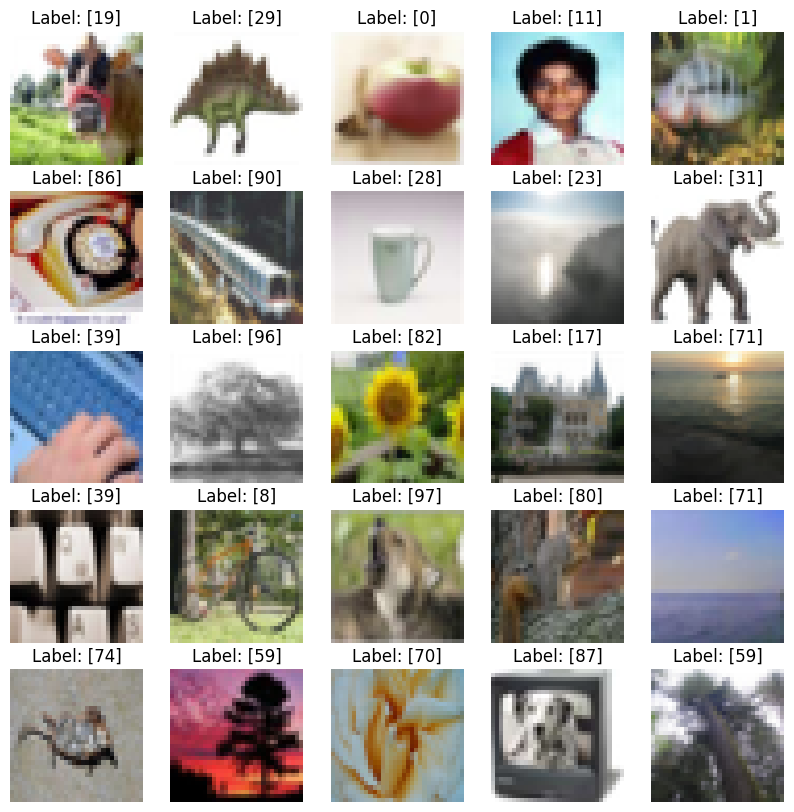

In [3]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
    
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.show()

In [4]:
import keras
from keras import models, layers

def MyConv2D(x, filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu"):
  x = layers.Conv2D(
    filters=filters,
    kernel_size=kernel_size,
    strides=strides,
    padding=padding,
  )(x)
  
  x = layers.BatchNormalization(axis=-1)(x)
  x = layers.Activation("relu")(x)
  return x

def Stem(input):
  x = MyConv2D(input, filters=32, kernel_size=(3,3), strides=(2,2), padding="valid", activation="relu")
  x = MyConv2D(x, filters=32, kernel_size=(3,3), padding="valid", activation="relu")
  x = MyConv2D(x, filters=64, kernel_size=(3,3), padding="same", activation="relu")
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="valid")(x)
  x = MyConv2D(x, filters=80, kernel_size=(1,1), padding="valid", activation="relu")
  x = MyConv2D(x, filters=192, kernel_size=(3,3), padding="valid", activation="relu")
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="valid")(x)
  return x

def InceptionA(input, filters=64):
  x1 = MyConv2D(input, filters=64, kernel_size=(1,1), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=96, kernel_size=(3,3), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=96, kernel_size=(3,3), padding="same", activation="relu")
  
  x2 = MyConv2D(input, filters=48, kernel_size=(1,1), padding="same", activation="relu")
  x2 = MyConv2D(x2, filters=64, kernel_size=(3,3), padding="same", activation="relu")
  
  x3 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding="same")(input)
  x3 = MyConv2D(x3, filters=filters, kernel_size=(1,1), padding="same", activation="relu")
  
  x4 = MyConv2D(input, filters=64, kernel_size=(1,1), padding="same", activation="relu")
  
  x = layers.Concatenate(axis=-1)([x1, x2, x3, x4])
  return x

def ReductionA(input):
  x1 = MyConv2D(input, filters=64, kernel_size=(1,1), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=96, kernel_size=(3,3), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=96, kernel_size=(3,3), strides=(2,2), padding="valid", activation="relu")
  
  x2 = MyConv2D(input, filters=384, kernel_size=(3,3), strides=(2,2), padding="valid", activation="relu")
  
  x3 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="valid")(input)
  
  x = layers.Concatenate(axis=-1)([x1, x2, x3])
  return x

def InceptionB(input, filters=192):
  x1 = MyConv2D(input, filters=filters, kernel_size=(1,1), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=filters, kernel_size=(7,1), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=filters, kernel_size=(1,7), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=filters, kernel_size=(7,1), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=192, kernel_size=(1,7), padding="same", activation="relu")
  
  x2 = MyConv2D(input, filters=filters, kernel_size=(1,1), padding="same", activation="relu")
  x2 = MyConv2D(x2, filters=filters, kernel_size=(1,7), padding="same", activation="relu")
  x2 = MyConv2D(x2, filters=192, kernel_size=(7,1), padding="same", activation="relu")
  
  x3 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding="same")(input)
  x3 = MyConv2D(x3, filters=192, kernel_size=(1,1), padding="same", activation="relu")
  
  x4 = MyConv2D(input, filters=192, kernel_size=(1,1), padding="same", activation="relu")
  
  x = layers.Concatenate(axis=-1)([x1, x2, x3, x4])
  return x

def ReductionB(input):
  x1 = MyConv2D(input, filters=192, kernel_size=(1,1), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=192, kernel_size=(1,7), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=192, kernel_size=(7,1), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=192, kernel_size=(3,3), strides=(2,2), padding='valid', activation="relu")
  
  
  x2 = MyConv2D(input, filters=192, kernel_size=(1,1), padding="same", activation="relu")
  x2 = MyConv2D(input, filters=320, kernel_size=(3,3), strides=(2,2), padding='valid', activation="relu")
  
  x3 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="valid")(input)
  
  x = layers.Concatenate(axis=-1)([x1, x2, x3])
  return x

def InceptionC(input):
  x1 = MyConv2D(input, filters=448, kernel_size=(1,1), padding="same", activation="relu")
  x1 = MyConv2D(x1, filters=384, kernel_size=(3,3), padding="same", activation="relu")
  x1_1 = MyConv2D(x1, filters=384, kernel_size=(1,3), padding="same", activation="relu")
  x1_2 = MyConv2D(x1, filters=384, kernel_size=(3,1), padding="same", activation="relu")
  
  x2 = MyConv2D(input, filters=384, kernel_size=(1,1), padding="same", activation="relu")
  x2_1 = MyConv2D(x2, filters=384, kernel_size=(1,3), padding="same", activation="relu")
  x2_2 = MyConv2D(x2, filters=384, kernel_size=(3,1), padding="same", activation="relu")
  
  x3 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding="same")(input)
  x3 = MyConv2D(x3, filters=192, kernel_size=(1,1), padding="same", activation="relu")
  
  x4 = MyConv2D(input, filters=320, kernel_size=(1,1), padding="same", activation="relu")
  
  x = layers.Concatenate(axis=-1)([x1_1, x1_2, x2_1, x2_2, x3, x4])
  return x

def Aux(input, n_classes = 1000):
  x = layers.AveragePooling2D((5, 5), strides=(3, 3), padding="same")(input)
  x = MyConv2D(x, filters=128, kernel_size=(1,1), padding="same", activation="relu")
  x = layers.Flatten()(x)
  x = layers.Dense(768, activation="relu")(x)
  x = layers.Dropout(rate = 0.2) (x)
  x = layers.Dense(n_classes, activation="softmax")(x)
  return x

def InceptionV3(input_shape=(299, 299, 3), n_classes = 1000):
  input = layers.Input(input_shape)
  x = layers.Rescaling(1./255)(input)
  x = layers.Resizing(299, 299)(x)
  x = layers.RandomColorJitter(
    value_range=(0, 1),
    brightness_factor=0.2,
    contrast_factor=0.2,
    saturation_factor=0.2,
    hue_factor=0.2
  )(x)
  x = layers.RandomFlip(
    mode="horizontal_and_vertical"
  )(x)

  x = Stem(x)
  
  x = InceptionA(x, 32)
  x = InceptionA(x)
  x = InceptionA(x)
  
  x = ReductionA(x)
  
  x = InceptionB(x, 128)
  x = InceptionB(x, 160)
  x = InceptionB(x, 160)
  x = InceptionB(x, 192)
  
  aux = Aux(x, n_classes)
  
  x = ReductionB(x)
  
  x = InceptionC(x)
  x = InceptionC(x)

  x = layers.GlobalAveragePooling2D()(x)

  x = layers.Dense(2048, activation="relu")(x)
  x = layers.Dropout(rate = 0.2) (x)
  output = layers.Dense(n_classes, activation="softmax")(x)
  
  model = models.Model(inputs=input, outputs=output)
  return model

In [4]:
from keras import optimizers

epochs = 50

initial_learning_rate = 1e-3
final_learning_rate = 1e-8
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1 / epochs)
batch_size = 32
steps_per_epoch = len(x_train) * 8 // 10 // batch_size

print(f'Initial learning rate: {initial_learning_rate}')
print(f'Final learning rate: {final_learning_rate}')
print(f'Learning rate decay factor: {learning_rate_decay_factor}')
print(f'Batch size: {batch_size}')
print(f'Steps per epoch: {steps_per_epoch}')

learning_rate = optimizers.schedules.ExponentialDecay(
  initial_learning_rate=initial_learning_rate,
  decay_steps=steps_per_epoch,
  decay_rate=learning_rate_decay_factor
)

model = InceptionV3(input_shape=(32, 32, 3), n_classes=100)
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Initial learning rate: 0.001
Final learning rate: 1e-08
Learning rate decay factor: 0.7943282347242815
Batch size: 32
Steps per epoch: 1250


I0000 00:00:1746625967.543833   62735 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 299, 299,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        896 │ resizing[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,496 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,200 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        320 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,432 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        768 │ conv2d_4[0][0]  

 Total params: 27,601,476 (105.29 MB)

 Trainable params: 27,567,428 (105.16 MB)

 Non-trainable params: 34,048 (133.00 KB)

In [5]:
history = model.fit(x_train, y_train, epochs=epochs, validation_split=0.2, steps_per_epoch=steps_per_epoch, batch_size=batch_size)

Epoch 1/50


I0000 00:00:1746625992.867346   62868 service.cc:148] XLA service 0x7f6244003bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746625992.867375   62868 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-05-07 16:53:13.608834: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746625997.109955   62868 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-07 16:53:19.961480: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16329_0', 88 bytes spill stores, 256 bytes spill loads

2025-05-07 16:53:20.355768: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16329', 364

   1/1250 ━━━━━━━━━━━━━━━━━━━━ 19:29:09 56s/step - accuracy: 0.0000e+00 - loss: 4.7449

I0000 00:00:1746626025.506699   62868 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.0319 - loss: 4.4258

2025-05-07 16:56:20.296356: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2722', 200 bytes spill stores, 200 bytes spill loads



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 227s 137ms/step - accuracy: 0.0319 - loss: 4.4256 - val_accuracy: 0.0568 - val_loss: 4.1758
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 165s 132ms/step - accuracy: 0.0820 - loss: 3.8752 - val_accuracy: 0.1069 - val_loss: 3.7508
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 166s 132ms/step - accuracy: 0.1295 - loss: 3.5777 - val_accuracy: 0.1521 - val_loss: 3.3983
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 164s 131ms/step - accuracy: 0.1966 - loss: 3.1886 - val_accuracy: 0.2559 - val_loss: 2.8909
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 165s 132ms/step - accuracy: 0.2637 - loss: 2.8386 - val_accuracy: 0.2968 - val_loss: 2.6892
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 165s 132ms/step - accuracy: 0.3280 - loss: 2.5209 - val_accuracy: 0.3519 - val_loss: 2.4532
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 164s 131ms/step - accuracy: 0.3785 - loss: 2.2830 - val_accuracy: 0.3899 - val_loss: 2.2659
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 162s 129ms/step - accuracy: 0.4

In [6]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5111 - loss: 1.9735


[2.0017733573913574, 0.5048999786376953]

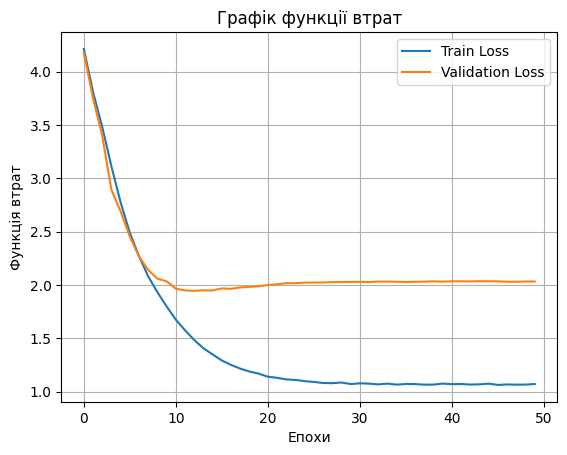

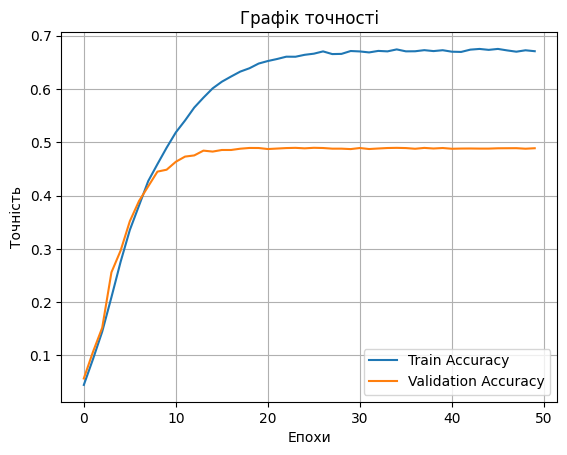

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Епохи')
plt.ylabel('Функція втрат')
plt.title('Графік функції втрат')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.title('Графік точності')
plt.legend()
plt.grid()
plt.show()

In [8]:
predictions = model.predict(x_test).argmax(axis=1)

predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step


array([72, 33, 55, ..., 51, 42, 54])

In [9]:
# from sklearn.metrics import confusion_matrix

# conf_matrix = confusion_matrix(y_test, predictions)
# fig, ax = plt.subplots(figsize=(30, 8))
# cax = ax.matshow(conf_matrix, cmap="Blues")

# plt.colorbar(cax)

# class_labels=range(100)

# ax.set_xticks(range(len(class_labels)))
# ax.set_yticks(range(len(class_labels)))
# ax.set_xticklabels(class_labels, fontsize=7)
# ax.set_yticklabels(class_labels, fontsize=7)

# plt.title("Confusion Matrix", pad=20)
# plt.xlabel("Predicted", labelpad=10)
# plt.ylabel("Actual", labelpad=10)

# for (i, j), value in np.ndenumerate(conf_matrix):
#     ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=7)

# plt.tight_layout()
# plt.show()

In [11]:
models.save_model(model, 'model.keras')

In [6]:
model = models.load_model('model.keras')
model.evaluate(x_test, y_test)

I0000 00:00:1746888923.895910    1765 service.cc:148] XLA service 0x7f8b98003240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746888923.896137    1765 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-05-10 17:55:23.956215: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746888924.431656    1765 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-10 17:55:25.155070: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2715_0', 88 bytes spill stores, 256 bytes spill loads

2025-05-10 17:55:25.285028: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2715_0', 204

  5/313 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6220 - loss: 1.7680

I0000 00:00:1746888929.093718    1765 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.5114 - loss: 1.9735


[2.0017712116241455, 0.5049999952316284]